In [1]:

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_ENABLE_CUDNN_OPTS'] = '1'
os.environ['DEEPREG_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import losses
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

print()
print('TensorFlow version : ',tf.version.VERSION)
print()



# for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done





TensorFlow version :  2.16.1



In [2]:
# initial parameters forimage_dataset_from_directory()
batch_size = None 
WIDTH, HEIGHT = 224, 224 

In [3]:

# metoda image_dataset_from_directory() load data
with tf.device('/CPU:0'):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='Vegetable Images/train', # defines the path to the data
        labels='inferred',          # 'inferred' - tags are generated from the directory structure
        label_mode='categorical',   # 'categoric' - labels are encoded as a categorical vector
        color_mode= 'rgb',          # 'grayscale', 'rgb', 'rgba' - the images will be converted to have 1, 3 or 4 channels.
        batch_size=batch_size,      #  package size
        image_size=(WIDTH, HEIGHT), # image output size width and height
        shuffle=True,               # True - shuffles data, False - data is arranged in alphabetical order
        seed=1234,                  # mixing coefficient
        validation_split=None,      # divides the data into training data and validation data
        subset=None,                # only used if validation_split is set. 
        crop_to_aspect_ratio=False, # only cuts out elements that do not fit into the defined ratio WIDTH/HEIGHT
        pad_to_aspect_ratio=True,   # add 0 value to height or width to keep the defined ratio WIDTH/HEIGHT
        verbose=True)               # displays numerical information about classes and the number of files found
    
    # returns the names of the classes (directory names)
    names_class = train_dataset.class_names
    print('class list train_dataset : ', list(names_class))
    dim_label = len(names_class)
    print('numarul de clase train_dataset : ', dim_label)
    
    
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='Vegetable Images/validation',       
        labels='inferred',          
        label_mode='categorical',   
        color_mode= 'rgb',          
        batch_size=batch_size,      
        image_size=(WIDTH, HEIGHT), 
        shuffle=True,               
        seed=1234,                  
        validation_split=None,       
        subset=None,              
        crop_to_aspect_ratio=False, 
        pad_to_aspect_ratio=True,   
        verbose=True)                
    
    
    names_class = validation_dataset.class_names
    print('class list validation_dataset : ', list(names_class))
    dim_label = len(names_class)
    print('numarul de clase validation_dataset : ', dim_label)
    
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory='Vegetable Images/test',        
        labels='inferred',         
        label_mode='categorical',   
        color_mode= 'rgb',          
        batch_size=batch_size,      
        image_size=(WIDTH, HEIGHT), 
        shuffle=True,               
        seed=1234,                  
        validation_split=None,      
        subset=None,              
        crop_to_aspect_ratio=False, 
        pad_to_aspect_ratio=True,   
        verbose=True)               
    
    
    names_class = test_dataset.class_names
    print('class list test_dataset : ', list(names_class))
    dim_label = len(names_class)
    print('number of classes test_dataset : ', dim_label)

    # Normalizeaza dataset 
    def normalization(x, y): 
        x = tf.cast(x, tf.float32) / 255.0
        y = tf.cast(y, tf.float32) 
        return x, y 
      
    train_dataset = train_dataset.map(normalization) 
    validation_dataset = validation_dataset.map(normalization)
    test_dataset = test_dataset.map(normalization)


    # split dataset into features and labels
    def split_data_feuture_and_label(dataset):
        # predefineste liste
        dataset_x = []
        dataset_y = []
    
        # separates data packets into features (x) and labels (y)
        for x, y in dataset:                                                        
            dataset_x.append(x.numpy())  
            dataset_y.append(y.numpy())
    
        # convert lists to array - uri 
        dataset_x = np.array(dataset_x)
        dataset_y = np.array(dataset_y)

        print(dataset_x.shape)
        print(dataset_y.shape)

        return dataset_x, dataset_y

    train_x, train_y = split_data_feuture_and_label(train_dataset)
    val_x, val_y = split_data_feuture_and_label(validation_dataset)
    test_x, test_y = split_data_feuture_and_label(test_dataset)


Found 15000 files belonging to 15 classes.
class list train_dataset :  ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
numarul de clase train_dataset :  15
Found 3000 files belonging to 15 classes.
class list validation_dataset :  ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
numarul de clase validation_dataset :  15
Found 3000 files belonging to 15 classes.
class list test_dataset :  ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
number of classes test_dataset :  15
(15000, 224, 224, 3)
(15000, 15)
(3000, 224, 224, 3)
(3000, 15)
(3000, 224, 224, 3)
(3000, 15)


In [4]:
# tf.keras.Sequential()

# Sequential Keras is a model that receives a single input as feedback and expects an output, as its name suggests.
# This type of model is capable of handling simple and structured problems in a sequential order.

# model with convolutional and Fully-Connected layers
model_conv_fc = tf.keras.Sequential()
model_conv_fc.add(Input(shape =(224,224,3)))
model_conv_fc.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", use_bias=True))
model_conv_fc.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same"))
model_conv_fc.add(Dropout(0.50))
model_conv_fc.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", use_bias=True))
model_conv_fc.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same"))
model_conv_fc.add(Dropout(0.50))
model_conv_fc.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", use_bias=True))
model_conv_fc.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same"))
model_conv_fc.add(Dropout(0.50))
model_conv_fc.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu", use_bias=True))
model_conv_fc.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same"))
model_conv_fc.add(Dropout(0.50))
model_conv_fc.add(Flatten())
model_conv_fc.add(Dense(32, activation="relu", use_bias=True))
model_conv_fc.add(Dropout(0.5))
model_conv_fc.add(Dense(dim_label, activation="softmax"))


In [5]:
# Optimizers are algorithms or methods used to minimize an error (loss function) or maximize efficiency.
# Mathematical functions depend on the trainable parameters of the model, i.e. weights and errors.
# They help to modify the weights and learning rate of the neural network to reduce losses.
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)


# The .compile() function configures and creates the model for the training and evaluation process.
# This prepares the model with an optimizer, loss, and metrics.
model_conv_fc.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# create a table containing the model summary
model_conv_fc.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,287 (423.00 KB)

 Trainable params: 108,287 (423.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Model training

# The 'model.fit()' function is used to train a machine learning model, for a fixed number of epochs.
# During training, the model adjusts its internal parameters (weights and errors) to minimize the loss function
# using optimization techniques such as Gradient Descent.

history = model_conv_fc.fit(train_x, train_y, batch_size=128 ,epochs=300, validation_data=(val_x, val_y), verbose = 1)


Epoch 1/300


I0000 00:00:1752787519.720809  539932 service.cc:145] XLA service 0x772230006070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752787519.721012  539932 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9


  8/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0606 - loss: 2.9464

I0000 00:00:1752787525.747618  539932 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.0623 - loss: 2.7708 - val_accuracy: 0.0677 - val_loss: 2.7080
Epoch 2/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0712 - loss: 2.7083 - val_accuracy: 0.0667 - val_loss: 2.7080
Epoch 3/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0648 - loss: 2.7088 - val_accuracy: 0.0700 - val_loss: 2.7081
Epoch 4/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0692 - loss: 2.7071 - val_accuracy: 0.0667 - val_loss: 2.7079
Epoch 5/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0797 - loss: 2.7039 - val_accuracy: 0.1067 - val_loss: 2.6882
Epoch 6/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1062 - loss: 2.6253 - val_accuracy: 0.2117 - val_loss: 2.6058
Epoch 7/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1432 - loss: 2.5263 - val_accuracy: 0.2570 - val_loss: 2.5472
Epoch 8/300
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1823 - loss: 2.4127 - val_accurac

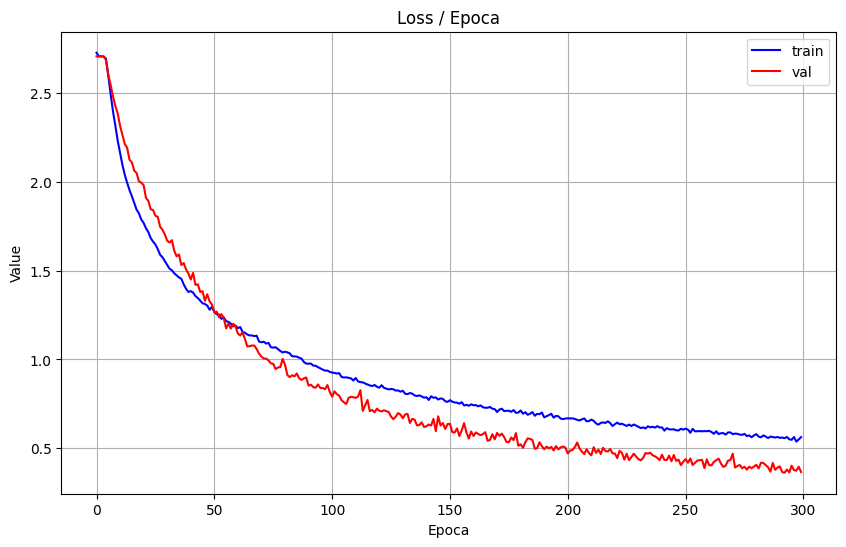

In [8]:
# ploteaza pierderea in raport cu evolutia epoci
plt.figure(figsize=(10,6)) 
# history este un dictionar din care putem extrage datele inregistrate in decursul antrenamentului
plt.plot(history.history['loss'], color = 'blue', label = 'train') 
plt.plot(history.history['val_loss'], color = 'red', label = 'val') 
plt.legend() 
plt.title('Loss / Epoca')
plt.grid()
plt.xlabel('Epoca')
plt.ylabel('Value')
plt.savefig("loss.jpg")
plt.show()

In [9]:
print('test')

# The evaluate() function allows us to evaluate how well it is trained with unseen data in the training cycle
# in this case the validation dataset is used
loss, accuracy = model_conv_fc.evaluate(test_x, test_y, verbose=1)
print()
print("Test loss :", loss)
print("Test accuracy :", accuracy)
print()


test
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9089 - loss: 0.3541

Test loss : 0.36614537239074707
Test accuracy : 0.9043333530426025



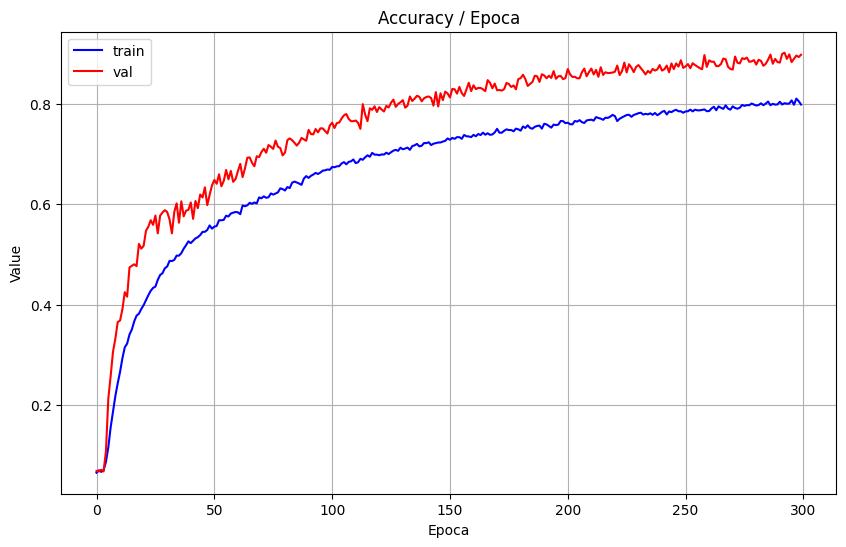

In [10]:
# plot Accuracy against epoch evolution
plt.figure(figsize=(10,6))
# history is a dictionary from which we can extract the data recorded during training
plt.plot(history.history['accuracy'], color = 'blue', label = 'train') 
plt.plot(history.history['val_accuracy'], color = 'red', label = 'val') 
plt.legend() 
plt.title('Accuracy / Epoca')
plt.grid()
plt.xlabel('Epoca')
plt.ylabel('Value')
plt.savefig("accuracy.jpg")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
8
Cauliflower



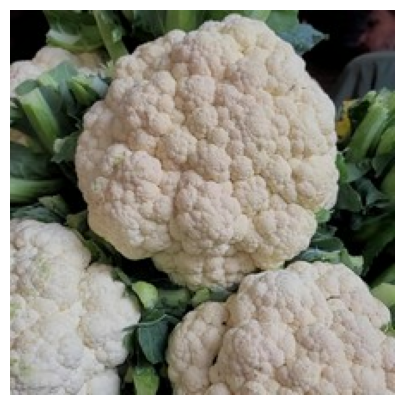

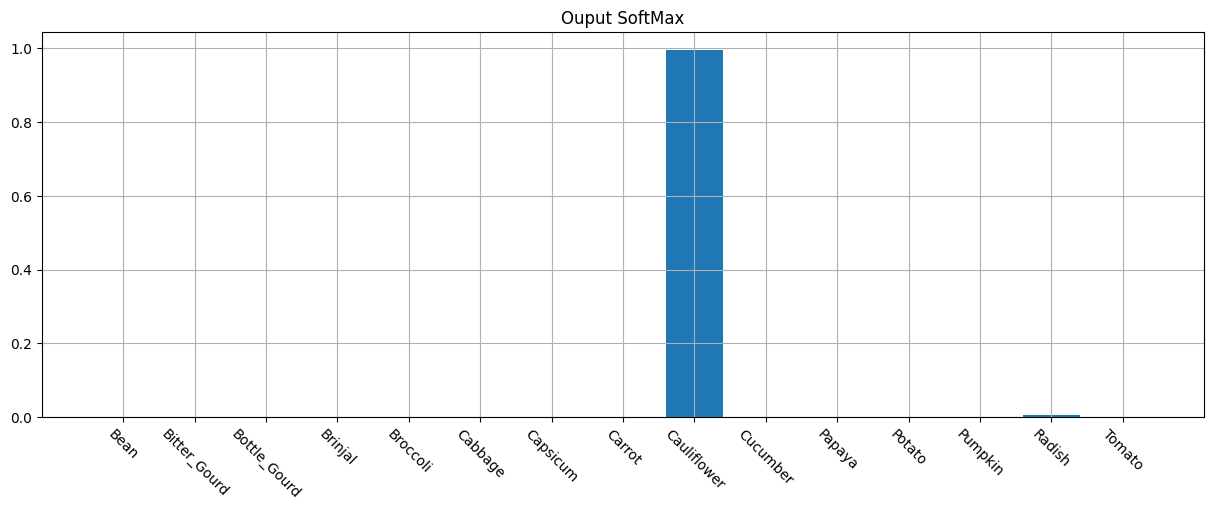

In [11]:
# Make some predictions
y_probs = model_conv_fc.predict(test_x)

nr_item = 1

# select from the softmax result (model output) the position with the highest value
pozitia = (tf.argmax(y_probs[nr_item])).numpy()
print(pozitia)

# identify the class name by position
print(names_class[pozitia])

# plot the image
print()
plt.figure(figsize=(5,5)) 
plt.imshow(test_x[nr_item])
plt.axis("off")
plt.show()

# plot SoftMax
plt.figure(figsize=(15,5)) 
plt.bar(names_class,y_probs[nr_item])
plt.xticks(rotation=-45)
plt.title('Ouput SoftMax')
plt.grid()
plt.show()

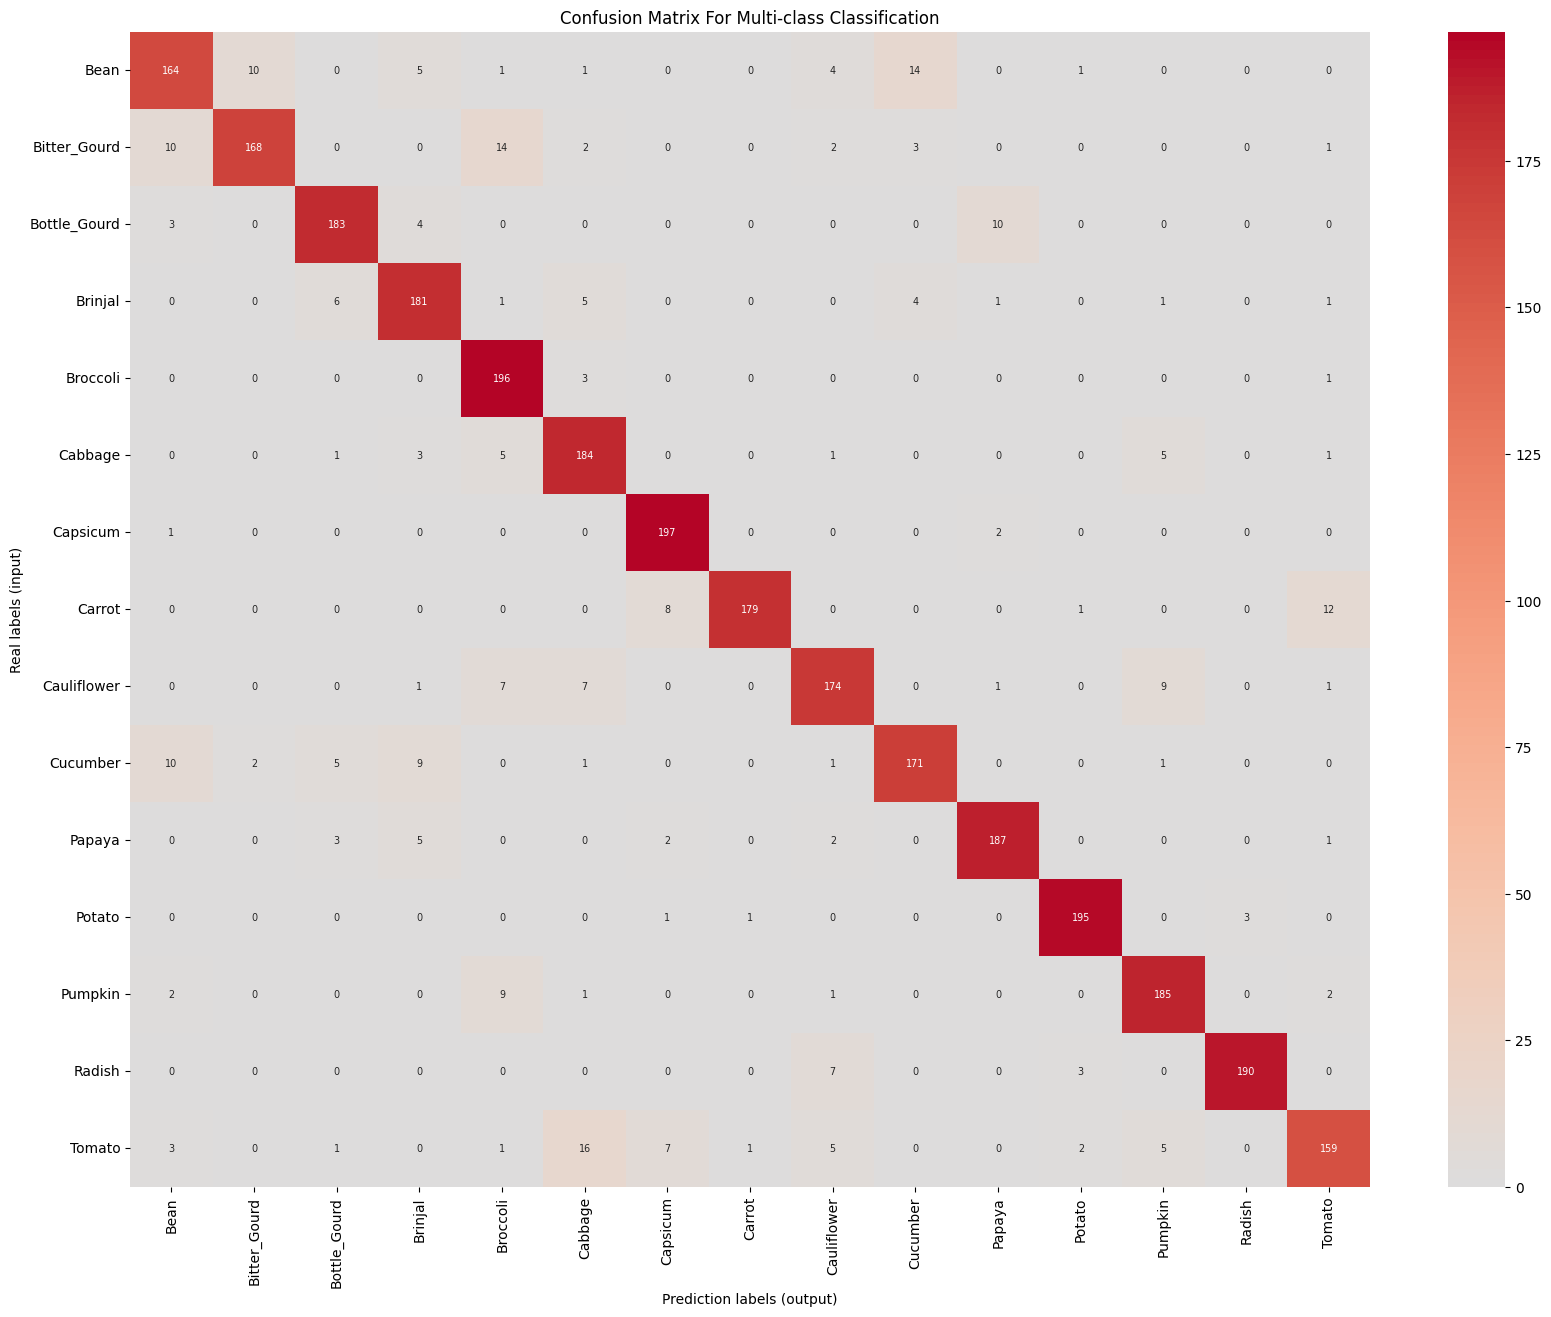

In [12]:
# creating the confusion matrix

# indicates the position of the maximum value on each row (axis = 1 sets 'argmax' to analyze on the column)
pred = tf.argmax(y_probs, axis = 1)
label = tf.argmax(test_y, axis = 1)

# create the confusion matrix
cm = tf.math.confusion_matrix(label, pred)

# create dataframe in pandas
cm_df = pd.DataFrame(cm, index = names_class, columns = names_class)

# plot the confusion matrix using 'sns.heatmap()'
plt.figure(figsize=(20, 15))
sns.heatmap(cm_df, annot=True, cmap='coolwarm', center=0, annot_kws={'size': 'x-small'}, fmt='d')
plt.title('Confusion Matrix For Multi-class Classification')
plt.xlabel('Prediction labels (output)')
plt.ylabel('Real labels (input)')
plt.savefig("confusion matrix.jpg")
plt.show()



In [13]:
#save model
try:
    os.mkdir('model_save')
    tf.keras.models.save_model(model=model_conv_fc, filepath='model_save/model_conv_fc.keras', overwrite=True)
except:
    tf.keras.models.save_model(model=model_conv_fc, filepath='model_save/model_conv_fc.keras', overwrite=True)



In [14]:
# extrage weights si biases din model
for layer in model_conv_fc.layers:                  # itereaza straturile modelul
    print("===== LAYER: ", layer.name, " =====")
    if layer.get_weights() != []:                   # conditioneaza listarea doar a coeficientilor diferiti de NaN
        weights = layer.get_weights()[0]            # in prima matrice sunt ponderi
        biases = layer.get_weights()[1]             # in a doua matrice este bias-ul
        print("weights:")
        print(weights.shape)
        print(weights)
        print("biases:")
        print(biases.shape)
        print(biases)
    else:
        print("=====")

===== LAYER:  conv2d  =====
weights:
(3, 3, 3, 16)
[[[[ 1.02786012e-02  1.85347542e-01  1.74065173e-01 -1.80064663e-01
     3.65370549e-02  1.63944021e-01  2.25877210e-01  2.11530505e-03
     8.80840048e-02 -1.20478578e-01 -1.93246622e-02 -8.32966715e-02
    -5.62698953e-02  1.45875290e-01 -1.09871618e-01  7.26224110e-02]
   [ 3.63872014e-02  9.71943736e-02 -1.94909766e-01  6.23454824e-02
     1.19276941e-01 -1.67967796e-01 -1.90899611e-01 -1.24455996e-01
    -1.28475472e-01  1.33038804e-01  4.11850289e-02 -3.10031860e-03
     7.68668056e-02 -1.33705169e-01  9.80089307e-02  1.69143870e-01]
   [-3.11636720e-02  3.61571871e-02 -1.00414485e-01  1.44238025e-01
    -2.98554730e-02  6.75635785e-02 -1.85467049e-01  3.06002703e-03
     2.22189680e-01 -1.37064606e-01  1.30026534e-01 -5.92521392e-02
     4.76774089e-02  5.65654300e-02  1.01558171e-01  4.78213280e-02]]

  [[-2.57411879e-02  1.59839932e-02 -1.00972578e-01 -1.37424916e-01
    -4.23580855e-02  7.28880242e-02  1.93287894e-01  3.69692